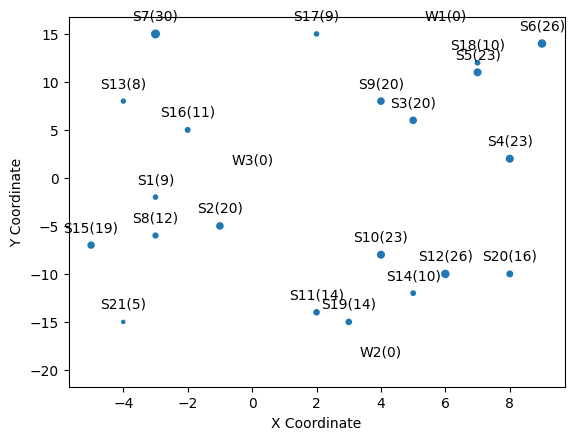

In [ ]:
#this is the code for plotting the showrooms and coordinates for Problem 2 with data in table 2
import matplotlib.pyplot as plt

# Sample Data given as coordinates (replace with your actual data)
x_coords = [-3, -1, 5, 8, 7, 9, -3, -3, 4, 4, 2, 6, -4, 5, -5, -2, 2, 7, 3, 8, -4, 6, 4, 0] #x-coordinate
y_coords = [-2, -5, 6, 2, 11, 14, 15, -6, 8, -8, -14, -10, 8, -12, -7, 5, 15, 12, -15, -10, -15, 15, -20, 0] #y-coordinate
order_qty = [9, 20, 20, 23, 23, 26, 30, 12, 20, 23, 14, 26, 8, 10, 19, 11, 9, 10, 14, 16, 5, 0, 0, 0] #order quantities of each location

# Create labels in the desired format
labels = [f"S{i+1}({qty})" for i, qty in enumerate(order_qty[:21])]  # S1 to S21
labels.extend([f"W{i+1}({qty})" for i, qty in enumerate(order_qty[21:])])  # W1 to W3

# Create the scatter plot
plt.scatter(x_coords, y_coords, s=order_qty)  # 's' controls size

# Add labels to each point
for i in range(len(x_coords)):
    plt.annotate(labels[i], (x_coords[i], y_coords[i]), textcoords="offset points", xytext=(0, 10), ha='center')

# Customize the plot (add titles, labels, etc.)
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")

plt.show()

In [ ]:
#this is the code for inputting data for fist problem
import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Read the CSV file into a DataFrame
t1 = pd.read_excel('table1.xlsx')

# Rename the first column header to `To`
t1 = t1.rename(columns={'Unnamed: 0': 'To'})

# Set first column `To` as the index
t1 = t1.set_index('To')

# Create a dictionary where keys are the column headers, and values are dictionaries of the corresponding row values
distance = t1.to_dict(orient='index')

t2 = pd.read_excel('table2.xlsx')

order_quantity = dict(zip(t2['Location'], t2['Order quantity']))

locations = ['S1 ', 'S2 ', 'S3 ', 'S4 ', 'S5 ', 'S6 ', 'S7 ', 'S8 ', 'S9 ', 'S10 ', 'S11 ', 'S12 ', 'S13 ', 'S14 ', 'S15 ', 'S16 ', 'S17 ', 'S18 ', 'S19 ', 'S20 ', 'S21 ', 'HO ','W1','W2','W3']

In [ ]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 34.4 MB/s eta 0:00:00


In [ ]:
#code for solving 2nd question
import pulp
import numpy as np
from itertools import combinations

def solve_tsp_exact(distance_dict):
    # Get store locations
    stores = [loc for loc in distance_dict.keys() if loc.startswith('S')]
    n = len(stores)

    # Create indices
    nodes = range(n)
    edges = [(i, j) for i in nodes for j in nodes if i != j]

    # Create optimization model
    tsp = pulp.LpProblem("TSP", pulp.LpMinimize)

    # Decision variables
    x = pulp.LpVariable.dicts("edge",
                             ((i, j) for i, j in edges),
                             cat="Binary")

    # Dummy variables for subtour elimination
    u = pulp.LpVariable.dicts("u",
                             ((i) for i in nodes),
                             lowBound=0,
                             upBound=n-1)

    # Objective function
    tsp += pulp.lpSum(distance_dict[stores[i]][stores[j]] * x[i,j]
                      for i, j in edges)

    # Constraints
    # Each node must be entered once
    for j in nodes:
        tsp += pulp.lpSum(x[i,j] for i in nodes if i != j) == 1

    # Each node must be exited once
    for i in nodes:
        tsp += pulp.lpSum(x[i,j] for j in nodes if i != j) == 1

    # Subtour elimination
    for i, j in edges:
        if i != 0 and j != 0:
            tsp += u[i] - u[j] + n * x[i,j] <= n - 1

    # Solve the problem
    tsp.solve(pulp.PULP_CBC_CMD(msg=False))

    # Extract the solution
    route = []
    current = 0
    for _ in range(n):
        route.append(stores[current])
        next_node = [j for j in nodes if j != current and x[current,j].value() == 1][0]
        current = next_node
    route.append(stores[0])

    total_distance = sum(distance_dict[route[i]][route[i+1]]
                        for i in range(len(route)-1))

    return route, total_distance

def main():
    route, total_distance = solve_tsp_exact(distance)
    print("\nOptimal Solution:")
    print("Route:", " -> ".join(route))
    print(f"Total Distance: {total_distance:.1f} kilometers")
    return route, total_distance

if __name__ == "__main__":
    optimal_route, optimal_distance = main()


Optimal Solution:
Route: S1  -> S13  -> S8  -> S9  -> S18  -> S20  -> S21  -> S19  -> S17  -> S11  -> S4  -> S7  -> S3  -> S14  -> S6  -> S12  -> S15  -> S10  -> S2  -> S16  -> S5  -> S1 
Total Distance: 43.0 kilometers


In [ ]:
#code for 3rd question
import pulp
import numpy as np

def solve_tsp_exact_from_ho(distance_dict):
    # Get locations including HO
    locations = ['HO '] + [loc for loc in distance_dict.keys() if loc.startswith('S')]
    n = len(locations)
    nodes = range(n)
    edges = [(i, j) for i in nodes for j in nodes if i != j]

    # Create model
    tsp = pulp.LpProblem("TSP_From_HO", pulp.LpMinimize)

    # Decision variables
    x = pulp.LpVariable.dicts("edge", edges, cat="Binary")
    u = pulp.LpVariable.dicts("u", ((i) for i in nodes), lowBound=0, upBound=n-1)

    # Objective: minimize total distance
    tsp += pulp.lpSum(distance_dict[locations[i]][locations[j]] * x[i,j]
                      for i, j in edges)

    # Constraints
    # Each node must be entered once
    for j in nodes:
        tsp += pulp.lpSum(x[i,j] for i in nodes if i != j) == 1

    # Each node must be exited once
    for i in nodes:
        tsp += pulp.lpSum(x[i,j] for j in nodes if i != j) == 1

    # Force start from HO (node 0)
    tsp += u[0] == 0

    # Subtour elimination (excluding HO)
    for i, j in edges:
        if i != 0 and j != 0:
            tsp += u[i] - u[j] + n * x[i,j] <= n - 1

    # Solve
    tsp.solve(pulp.PULP_CBC_CMD(msg=False))

    # Extract solution
    route = []
    current = 0  # Start from HO
    for _ in range(n):
        route.append(locations[current])
        next_node = [j for j in nodes if j != current and x[current,j].value() == 1][0]
        current = next_node

    route.append(locations[0])  # Return to HO

    total_distance = sum(distance_dict[route[i]][route[i+1]]
                        for i in range(len(route)-1))

    return route, total_distance

def main():
    route, total_distance = solve_tsp_exact_from_ho(distance)
    print("\nOptimal Solution:")
    print("Route:", " -> ".join(route))
    print(f"Total Distance: {total_distance:.1f} kilometers")
    return route, total_distance

if __name__ == "__main__":
    optimal_route, optimal_distance = main()


Optimal Solution:
Route: HO  -> S12  -> S15  -> S10  -> S8  -> S9  -> S18  -> S20  -> S21  -> S19  -> S17  -> S13  -> S1  -> S7  -> S14  -> S3  -> S6  -> S2  -> S16  -> S5  -> S4  -> S11  -> HO 
Total Distance: 44.0 kilometers


In [ ]:
#code for creating new distance matrix with x and y coordinates
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd

# Extract the coordinates from the table
coordinates = np.array([
    [-3, -2], [-1, -5], [5, 6], [8, 2], [7, 11], [9, 14], [-3, 15], [-3, -6],
    [4, 8], [4, -8], [2, -14], [6, -10], [-4, 8], [5, -12], [-5, -7], [-2, 5],
    [2, 15], [7, 12], [3, -15], [8, -10], [-4, -15], [6, 15], [4, -20], [0, 0]
])

# Calculate the distance matrix using Euclidean distance
distance_matrix = cdist(coordinates, coordinates, 'euclidean')

# Create labels for rows and columns
labels = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14',
          'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 'S21', 'W1', 'W2', 'W3']

# Create a Pandas DataFrame for easier Excel export
df = pd.DataFrame(distance_matrix, index=labels, columns=labels)

# Save the DataFrame to an Excel file
df.to_excel("distance_matrix.xlsx", index=True)

In [ ]:
#code for inputting data for problem 2
import pandas as pd

# Read the CSV file into a DataFrame
t3 = pd.read_excel('table3.xlsx')

# Rename the first column header to `To`
t3 = t3.rename(columns={'Unnamed: 0': 'To'})

# Set first column `To` as the index
t3 = t3.set_index('To')

# Apply rounding to all values in the DataFrame
t3 = t3.applymap(lambda x: round(x, 1))

# Create a dictionary where keys are the column headers,
# and values are dictionaries of the corresponding row values
distance2 = t3.to_dict(orient='index')

<ipython-input-8-ef51eb447d5b>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  t3 = t3.applymap(lambda x: round(x, 1))


In [ ]:
!pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 12.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.1 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.26.1 which is incompatible.
tensorflow-metadata 1.13.1 requires absl-py<2.0.0,>=0.9, but you have absl-py 2.1.0 which is incompatible

In [ ]:
#code for 12th question
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np

def create_data_model():
    """Creates and stores data for the problem"""
    data = {}

    # Warehouse assignments
    w1_locations = ['S5', 'S6', 'S7', 'S9', 'S17', 'S18']
    w2_locations = ['S11', 'S12', 'S14', 'S19', 'S20', 'S21']
    w3_locations = ['S1', 'S2', 'S3', 'S4', 'S8', 'S10', 'S13', 'S15', 'S16']

    # Order quantities
    demands = {
        'S1': 9, 'S2': 20, 'S3': 20, 'S4': 23, 'S5': 23, 'S6': 26, 'S7': 30,
        'S8': 12, 'S9': 20, 'S10': 23, 'S11': 14, 'S12': 26, 'S13': 8,
        'S14': 10, 'S15': 19, 'S16': 11, 'S17': 9, 'S18': 10, 'S19': 14,
        'S20': 16, 'S21': 5
    }

    # Process W1 locations
    data['w1_locations'] = ['W1'] + [loc + ' ' for loc in w1_locations]
    data['w1_demands'] = [0] + [demands[loc.strip()] for loc in w1_locations]

    # Calculate total quantity for W1
    data['total_quantity'] = sum(demands[loc.strip()] for loc in w1_locations)

    # Create distance matrix for W1
    n = len(data['w1_locations'])
    distance_matrix = np.zeros((n, n))
    for i, loc1 in enumerate(data['w1_locations']):
        for j, loc2 in enumerate(data['w1_locations']):
            distance_matrix[i][j] = distance2[loc1][loc2]

    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = 5
    data['depot'] = 0
    data['vehicle_capacity'] = 50

    return data

def get_solution_details(data, manager, routing, solution):
    """Calculates and returns the solution details"""
    total_distance = 0
    routes = []

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        if not routing.IsVehicleUsed(solution, vehicle_id):
            continue

        route_distance = 0
        route_load = 0
        route = []

        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            route_load += data['w1_demands'][node_index]
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += data['distance_matrix'][manager.IndexToNode(previous_index)][manager.IndexToNode(index)]

        routes.append({
            'vehicle_id': vehicle_id,
            'distance': route_distance,
            'load': route_load,
            'locations': [data['w1_locations'][i] for i in route]
        })
        total_distance += route_distance

    # Calculate costs
    fixed_cost = 5000 * len(routes)  # Rs. 5000 per truck used
    variable_cost = 40 * total_distance  # Rs. 40 per kilometer
    total_cost = fixed_cost + variable_cost

    return {
        'total_cost': total_cost,
        'total_distance': total_distance,
        'vehicles_used': len(routes),
        'routes': routes
    }

def solve_vrp():
    """Solve the VRP problem"""
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'],
        data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['w1_demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        [data['vehicle_capacity']] * data['num_vehicles'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Set solution parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(30)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        results = get_solution_details(data, manager, routing, solution)
        results['total_quantity'] = data['total_quantity']
        return results
    return None

# Run the solver and get results
results = solve_vrp()
if results:
    print("\nWarehouse 1 (W1) Delivery Solution:")
    print("=" * 40)
    print(f"Total quantity to be shipped: {results['total_quantity']} units")
    print(f"Total cost: Rs. {results['total_cost']:.2f}")
    print(f"Number of trucks required: {results['vehicles_used']}")
    print(f"Total distance traveled: {results['total_distance']:.2f} km")

    print("\nDetailed Route Information:")
    print("=" * 40)
    for route in results['routes']:
        print(f"\nTruck {route['vehicle_id'] + 1}:")
        print(f"Load: {route['load']} units")
        print(f"Distance: {route['distance']:.2f} km")
        print("Route:", ' -> '.join(loc.strip() for loc in route['locations']))


Warehouse 1 (W1) Delivery Solution:
Total quantity to be shipped: 118 units
Total cost: Rs. 17112.00
Number of trucks required: 3
Total distance traveled: 52.80 km

Detailed Route Information:

Truck 3:
Load: 49 units
Distance: 11.10 km
Route: W1 -> S6 -> S5

Truck 4:
Load: 30 units
Distance: 18.00 km
Route: W1 -> S7

Truck 5:
Load: 39 units
Distance: 23.70 km
Route: W1 -> S18 -> S17 -> S9


In [ ]:
#code for 13th question
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np

def create_data_model():
    """Creates and stores data for the problem"""
    data = {}

    # Warehouse assignments
    w1_locations = ['S5', 'S6', 'S7', 'S9', 'S17', 'S18']
    w2_locations = ['S11', 'S12', 'S14', 'S19', 'S20', 'S21']
    w3_locations = ['S1', 'S2', 'S3', 'S4', 'S8', 'S10', 'S13', 'S15', 'S16']

    # Order quantities
    demands = {
        'S1': 9, 'S2': 20, 'S3': 20, 'S4': 23, 'S5': 23, 'S6': 26, 'S7': 30,
        'S8': 12, 'S9': 20, 'S10': 23, 'S11': 14, 'S12': 26, 'S13': 8,
        'S14': 10, 'S15': 19, 'S16': 11, 'S17': 9, 'S18': 10, 'S19': 14,
        'S20': 16, 'S21': 5
    }

    # Process W2 locations
    data['w2_locations'] = ['W2'] + [loc + ' ' for loc in w2_locations]
    data['w2_demands'] = [0] + [demands[loc.strip()] for loc in w2_locations]

    # Calculate total quantity for W2
    data['total_quantity'] = sum(demands[loc.strip()] for loc in w2_locations)

    # Create distance matrix for W2
    n = len(data['w2_locations'])
    distance_matrix = np.zeros((n, n))
    for i, loc1 in enumerate(data['w2_locations']):
        for j, loc2 in enumerate(data['w2_locations']):
            distance_matrix[i][j] = distance2[loc1][loc2]

    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = 5
    data['depot'] = 0
    data['vehicle_capacity'] = 50

    return data

def get_solution_details(data, manager, routing, solution):
    """Calculates and returns the solution details"""
    total_distance = 0
    routes = []

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        if not routing.IsVehicleUsed(solution, vehicle_id):
            continue

        route_distance = 0
        route_load = 0
        route = []

        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            route_load += data['w2_demands'][node_index]
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += data['distance_matrix'][manager.IndexToNode(previous_index)][manager.IndexToNode(index)]

        routes.append({
            'vehicle_id': vehicle_id,
            'distance': route_distance,
            'load': route_load,
            'locations': [data['w2_locations'][i] for i in route]
        })
        total_distance += route_distance

    # Calculate costs
    fixed_cost = 5000 * len(routes)  # Rs. 5000 per truck used
    variable_cost = 40 * total_distance  # Rs. 40 per kilometer
    total_cost = fixed_cost + variable_cost

    return {
        'total_cost': total_cost,
        'total_distance': total_distance,
        'vehicles_used': len(routes),
        'routes': routes
    }

def solve_vrp_w2():
    """Solve the VRP problem for Warehouse 2"""
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'],
        data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['w2_demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        [data['vehicle_capacity']] * data['num_vehicles'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Set solution parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(30)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        results = get_solution_details(data, manager, routing, solution)
        results['total_quantity'] = data['total_quantity']
        return results
    return None

# Run the solver and get results for Warehouse 2
results = solve_vrp_w2()
if results:
    print("\nWarehouse 2 (W2) Delivery Solution:")
    print("=" * 40)
    print(f"Total quantity to be shipped: {results['total_quantity']} units")
    print(f"Total cost: Rs. {results['total_cost']:.2f}")
    print(f"Number of trucks required: {results['vehicles_used']}")
    print(f"Total distance traveled: {results['total_distance']:.2f} km")

    print("\nDetailed Route Information:")
    print("=" * 40)
    for route in results['routes']:
        print(f"\nTruck {route['vehicle_id'] + 1}:")
        print(f"Load: {route['load']} units")
        print(f"Distance: {route['distance']:.2f} km")
        print("Route:", ' -> '.join(loc.strip() for loc in route['locations']))


Warehouse 2 (W2) Delivery Solution:
Total quantity to be shipped: 85 units
Total cost: Rs. 12548.00
Number of trucks required: 2
Total distance traveled: 63.70 km

Detailed Route Information:

Truck 4:
Load: 40 units
Distance: 22.30 km
Route: W2 -> S12 -> S11

Truck 5:
Load: 45 units
Distance: 41.40 km
Route: W2 -> S21 -> S20 -> S19 -> S14


In [ ]:
#code for 14th question
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np

def create_data_model():
    """Creates and stores data for the problem"""
    data = {}

    # Warehouse assignments
    w1_locations = ['S5', 'S6', 'S7', 'S9', 'S17', 'S18']
    w2_locations = ['S11', 'S12', 'S14', 'S19', 'S20', 'S21']
    w3_locations = ['S1', 'S2', 'S3', 'S4', 'S8', 'S10', 'S13', 'S15', 'S16']

    # Order quantities
    demands = {
        'S1': 9, 'S2': 20, 'S3': 20, 'S4': 23, 'S5': 23, 'S6': 26, 'S7': 30,
        'S8': 12, 'S9': 20, 'S10': 23, 'S11': 14, 'S12': 26, 'S13': 8,
        'S14': 10, 'S15': 19, 'S16': 11, 'S17': 9, 'S18': 10, 'S19': 14,
        'S20': 16, 'S21': 5
    }

    # Process W3 locations
    data['w3_locations'] = ['W3'] + [loc + ' ' for loc in w3_locations]
    data['w3_demands'] = [0] + [demands[loc.strip()] for loc in w3_locations]

    # Calculate total quantity for W3
    data['total_quantity'] = sum(demands[loc.strip()] for loc in w3_locations)

    # Create distance matrix for W3
    n = len(data['w3_locations'])
    distance_matrix = np.zeros((n, n))
    for i, loc1 in enumerate(data['w3_locations']):
        for j, loc2 in enumerate(data['w3_locations']):
            distance_matrix[i][j] = distance2[loc1][loc2]

    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = 5
    data['depot'] = 0
    data['vehicle_capacity'] = 50

    return data

def get_solution_details(data, manager, routing, solution):
    """Calculates and returns the solution details"""
    total_distance = 0
    routes = []

    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        if not routing.IsVehicleUsed(solution, vehicle_id):
            continue

        route_distance = 0
        route_load = 0
        route = []

        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            route_load += data['w3_demands'][node_index]
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += data['distance_matrix'][manager.IndexToNode(previous_index)][manager.IndexToNode(index)]

        routes.append({
            'vehicle_id': vehicle_id,
            'distance': route_distance,
            'load': route_load,
            'locations': [data['w3_locations'][i] for i in route]
        })
        total_distance += route_distance

    # Calculate costs
    fixed_cost = 5000 * len(routes)  # Rs. 5000 per truck used
    variable_cost = 40 * total_distance  # Rs. 40 per kilometer
    total_cost = fixed_cost + variable_cost

    return {
        'total_cost': total_cost,
        'total_distance': total_distance,
        'vehicles_used': len(routes),
        'routes': routes
    }

def solve_vrp_w3():
    """Solve the VRP problem for Warehouse 3"""
    data = create_data_model()
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'],
        data['depot'])
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['w3_demands'][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        [data['vehicle_capacity']] * data['num_vehicles'],  # vehicle maximum capacities
        True,  # start cumul to zero
        'Capacity')

    # Set solution parameters
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(30)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    if solution:
        results = get_solution_details(data, manager, routing, solution)
        results['total_quantity'] = data['total_quantity']
        return results
    return None

# Run the solver and get results for Warehouse 3
results = solve_vrp_w3()
if results:
    print("\nWarehouse 3 (W3) Delivery Solution:")
    print("=" * 40)
    print(f"Total quantity to be shipped: {results['total_quantity']} units")
    print(f"Total cost: Rs. {results['total_cost']:.2f}")
    print(f"Number of trucks required: {results['vehicles_used']}")
    print(f"Total distance traveled: {results['total_distance']:.2f} km")

    print("\nDetailed Route Information:")
    print("=" * 40)
    for route in results['routes']:
        print(f"\nTruck {route['vehicle_id'] + 1}:")
        print(f"Load: {route['load']} units")
        print(f"Distance: {route['distance']:.2f} km")
        print("Route:", ' -> '.join(loc.strip() for loc in route['locations']))


Warehouse 3 (W3) Delivery Solution:
Total quantity to be shipped: 145 units
Total cost: Rs. 19392.00
Number of trucks required: 3
Total distance traveled: 109.80 km

Detailed Route Information:

Truck 3:
Load: 49 units
Distance: 27.90 km
Route: W3 -> S3 -> S2 -> S1

Truck 4:
Load: 46 units
Distance: 28.10 km
Route: W3 -> S10 -> S4

Truck 5:
Load: 50 units
Distance: 53.80 km
Route: W3 -> S16 -> S15 -> S13 -> S8
